# Chromosome Painting

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra
using DataFrames
using Plots
# using ProfileView

BLAS.set_num_threads(1)

# Download population data

Download [population code](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/) for each 1000 genomes sample. Different population code is explained [here](https://www.internationalgenome.org/category/population/). 

In [ ]:
# run this code in terminal
# wget -r -l3 -N --no-parent ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/

# Get each sample's population origin

In [2]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/country_origin")
df = DataFrame(sample = String[], population = String[])
refID_to_population = Dict{String, String}()
for population in readdir("data/")
    for sample in readdir("data/" * population)
        sample == ".DS_Store" && continue
        push!(df, (sample, population))
        refID_to_population[sample] = population
    end
end
refID_to_population

Dict{String,String} with 2709 entries:
  "HG01791" => "GBR"
  "HG02736" => "PJL"
  "HG00182" => "FIN"
  "HG03914" => "BEB"
  "HG00149" => "GBR"
  "NA12156" => "CEU"
  "HG02642" => "GWD"
  "HG02851" => "GWD"
  "NA19835" => "ASW"
  "NA19019" => "LWK"
  "HG01131" => "CLM"
  "HG03725" => "ITU"
  "HG03578" => "MSL"
  "NA18550" => "CHB"
  "HG02401" => "CDX"
  "HG01350" => "CLM"
  "HG03973" => "ITU"
  "NA07000" => "CEU"
  "HG01709" => "IBS"
  "HG01395" => "PUR"
  "HG02388" => "CDX"
  "HG01980" => "PEL"
  "HG01979" => "PEL"
  "HG01122" => "CLM"
  "HG03869" => "ITU"
  ⋮         => ⋮

# Compute phase information

In [3]:
# compute each person's phase information
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.jlso"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, max_d=d,
    phase=true);

Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:07


Total windows = 2367, averaging ~ 527 unique haplotypes per window.

Timings: 
    Data import                     = 17.8489 seconds
        import target data             = 4.41795 seconds
        import compressed haplotypes   = 13.431 seconds
    Computing haplotype pair        = 8.062 seconds
        BLAS3 mul! to get M and N      = 0.304455 seconds per thread
        haplopair search               = 3.66319 seconds per thread
        initializing missing           = 0.0228689 seconds per thread
        allocating and viewing         = 0.0606441 seconds per thread
        index conversion               = 0.00144102 seconds per thread
    Phasing by win-win intersection = 0.71595 seconds
        Window-by-window intersection  = 0.101616 seconds per thread
        Breakpoint search              = 0.0919472 seconds per thread
        Recording result               = 0.0121334 seconds per thread
    Imputation                     = 3.29746 seconds
        Imputing missing              

In [4]:
# check ultra-compression matches vcf.gz compression
X_answer = convert_gt(UInt8, "mendel.imputed.vcf.gz", trans=true)
X1, X2, _, _, H = convert_compressed(UInt8, outfile, "ref.chr18.excludeTarget.vcf.gz")
X_phased = X1 + X2
all(X_answer .== X_phased)

importing reference data...100%|████████████████████████| Time: 0:03:50


true

In [31]:
minimum([length(ph[i].strand2.start) for i in 1:100])

739

# Compute sample composition in 1000 genomes

In [10]:
# need compressed reference panel
reffile = "ref.chr18.maxd$d.maf$maf.excludeTarget.jlso"
compressed_Hunique = JLSO.load(reffile)[:compressed_Hunique]
panelID = compressed_Hunique.sampleID

# get sample's ancestry
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reader = VCF.Reader(openvcf(tgtfile, "r"))
tgtID  = VCF.header(reader).sampleID
sample_population = [refID_to_population[id] for id in tgtID];

In [11]:
findall(x -> x == "CHS", sample_population)

8-element Array{Int64,1}:
  4
  5
  6
  7
  8
  9
 10
 11

  0.000321 seconds (8 allocations: 1.250 KiB)
  0.000360 seconds (8 allocations: 1.250 KiB)
  0.000391 seconds (8 allocations: 1.250 KiB)


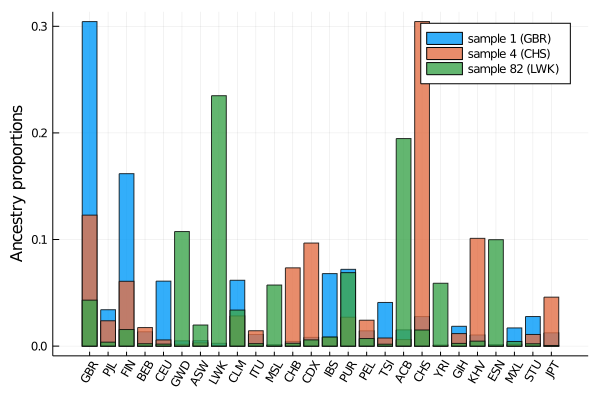

In [12]:
populations = unique_populations(refID_to_population)
@time sample1_comp = composition(ph[1], panelID, refID_to_population)
@time sample4_comp = composition(ph[4], panelID, refID_to_population)
@time sample82_comp = composition(ph[82], panelID, refID_to_population)

barplot = bar(sample1_comp, xticks=(1:1:26, populations), xrotation=60, 
    ylabel = "Ancestry pr hoportions", label="sample 1 (GBR)", alpha=0.8)
bar!(barplot, sample4_comp, label="sample 4 (CHS)", alpha=0.8)
bar!(barplot, sample82_comp, label="sample 82 (LWK)", alpha=0.8)

In [26]:
savefig(barplot, "admixture.png") # remember to set dpi=300

# Try painting an actual chromosome

In [23]:
populations = unique_populations(refID_to_population)
@time sample1_s1_comp, sample1_s2_comp = paint(ph[1], panelID, refID_to_population)
@time sample4_s1_comp, sample4_s2_comp = paint(ph[4], panelID, refID_to_population)
@time sample82_s1_comp, sample82_s2_comp = paint(ph[82], panelID, refID_to_population)

  0.000399 seconds (12 allocations: 25.125 KiB)
  0.000388 seconds (12 allocations: 30.000 KiB)
  0.000443 seconds (12 allocations: 36.125 KiB)


(([0.0003201962932294318, 0.0010039854469025408, 9.383041559836829e-5, 0.0020994555490134906, 0.0001254981808628176, 0.000985219363782867, 0.00023926755977583914, 0.000982873603392908, 0.00014661002437245046, 9.031177501342947e-5  …  0.0003272335743993094, 0.00020290827373147143, 0.0022143978081214915, 0.00014543714417747085, 0.0007353958822522115, 0.0007342230020572319, 0.00044569447409224935, 0.002151062277592593, 0.0001642032272971445, 0.0019985878522452444], ["GBR", "PUR", "GBR", "PUR", "GBR", "YRI", "ACB", "LWK", "PUR", "FIN"  …  "JPT", "ACB", "ESN", "ACB", "ESN", "ESN", "GWD", "ACB", "GBR", "ACB"]), ([0.0003201962932294318, 0.0009089821511091928, 0.0001888337113917162, 0.0032101730936591752, 0.00023926755977583914, 0.000982873603392908, 0.00014661002437245046, 9.031177501342947e-5, 0.0005477350510554749, 0.00015012866495738925  …  0.0010813955397711945, 0.00040698942765792244, 0.000260379403285472, 0.0018074083804635692, 0.0010485548943117656, 0.00010555921754816432, 0.0015470289

In [58]:
using StatsPlots
sample1_s1 = groupedbar(sample1_s1_comp[1]', bar_position = :stack, 
    lw = 0, bar_width=0.7)
sample1_s2 = groupedbar(sample1_s2_comp[1]', bar_position = :stack, 
    lw = 0, bar_width=0.7)
test = plot(sample1_s1, sample1_s2, layout=(1, 2))